<a href="https://colab.research.google.com/github/menvuthy/codes/blob/main/land_use_classification_with_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Land Use Classification with Random Forests Classifier**

---
*Written by Men Vuthy, 2022*


**Objective**

The objective is to classify the land use into 5 classes using supervised learning method. The classifier used in this classification is *Random Forests Classifier* with 500 ensembles. The target classes of land use are: Forest, 
Water, Herbaceous, Barren and Urban.

---



**Code**

*Importing data from GitHub*

In [ ]:
!git clone https://github.com/menvuthy/sample_images.git

fatal: destination path 'sample_images' already exists and is not an empty directory.


*Importing modules*

In [ ]:
# Import Python 3's print function and division
from __future__ import print_function, division

# Import GDAL, NumPy, Pandas and matplotlib
from osgeo import gdal, gdal_array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Import scikit-learn modules
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

In [ ]:
# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()

In [ ]:
# Read in our image and ROI image
img_ds = gdal.Open('/content/sample_images/data/LE70220491999322EDC01_stack.gtif', gdal.GA_ReadOnly)
roi_ds = gdal.Open('/content/sample_images/data/training_data.gtif', gdal.GA_ReadOnly)

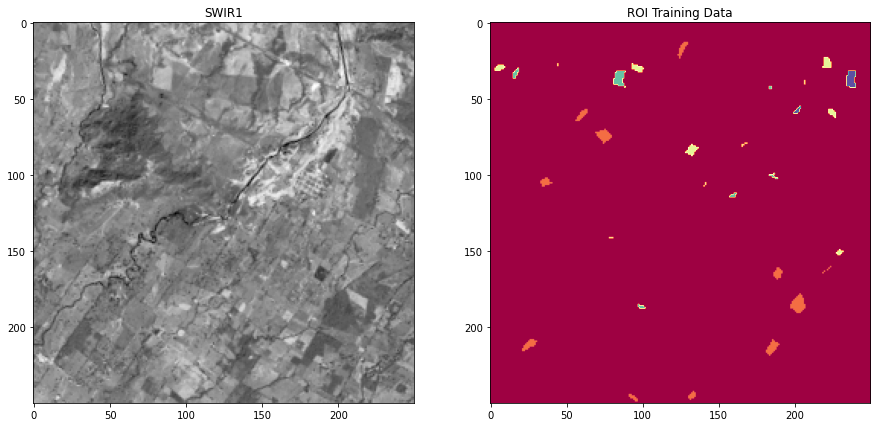

In [ ]:
img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()
    
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

# Display them
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img[:, :, 4], cmap=plt.cm.Greys_r)
plt.title('SWIR1')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('ROI Training Data')

plt.show()

In [ ]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
# We will need a "X" matrix containing our features, and a "y" array containing our labels
#     These will have n_samples rows
#     In other languages we would need to allocate these and them loop to fill them, but NumPy can be faster

X = img[roi > 0, :]  # include 8th band, which is Fmask, for now
y = roi[roi > 0]

print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

# Mask out clouds, cloud shadows, and snow using Fmask
clear = X[:, 7] <= 1

X = X[clear, :7]  # we can ditch the Fmask band now
y = y[clear]

print('After masking, our X matrix is sized: {sz}'.format(sz=X.shape))
print('After masking, our y array is sized: {sz}'.format(sz=y.shape))

We have 718 samples
The training data include 5 classes: [1 2 3 4 5]
Our X matrix is sized: (718, 8)
Our y array is sized: (718,)
After masking, our X matrix is sized: (718, 7)
After masking, our y array is sized: (718,)


In [ ]:
# Create a dataframe with the four feature variables
df = pd.DataFrame(X, columns = [1, 2, 3, 4, 5, 6, 7])
df['class'] = y
df.head()

,1,2,3,4,5,6,7,class
0,348,507,346,3001,1611,646,2587,1
1,369,529,365,3030,1662,726,2587,1
2,348,486,365,3143,1662,646,2637,1
3,327,441,327,3002,1561,646,2537,1
4,327,463,346,2887,1486,567,2537,1


In [ ]:
# Create Test and Train Data
df['train'] = np.random.uniform(0, 1, len(X)) <= .75
df.head()

,1,2,3,4,5,6,7,class,train
0,348,507,346,3001,1611,646,2587,1,True
1,369,529,365,3030,1662,726,2587,1,False
2,348,486,365,3143,1662,646,2637,1,False
3,327,441,327,3002,1561,646,2537,1,True
4,327,463,346,2887,1486,567,2537,1,True


In [ ]:
# Create dataframes with test rows and training rows
train, test = df[df['train']==True], df[df['train']==False]

# show the number of observations for test and train dataframe
print('Training data:', len(train))
print('Testing data:', len(test))

Training data: 545
Testing data: 173


In [ ]:
# Create a list of the feature column's names
features = df.columns[:7]

features

Index([1, 2, 3, 4, 5, 6, 7], dtype='object')

In [ ]:
# Converting each land use class name into digits
# classes = pd.factorize(train['class'])[0]

# Since our land use is already in digits, there's no need to factorize
classes = train['class']

*Training model with Random Forest Classifier*

In [ ]:
# Initialize our model with 500 trees
clf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=0)

# Fit our model to training data
clf = clf.fit(train[features], classes)


*Saving and loading model*

In [ ]:
# save
joblib.dump(clf, "./random_forest.joblib")

# load, no need to initialize the loaded_rf
rfc_model = joblib.load("./random_forest.joblib")

In [ ]:
bands = [1, 2, 3, 4, 5, 7, 6]

for b, imp in zip(bands, rfc_model.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band 1 importance: 0.13095182562024518
Band 2 importance: 0.19245451507256442
Band 3 importance: 0.11298410404880553
Band 4 importance: 0.09672074356542398
Band 5 importance: 0.20001544067809507
Band 7 importance: 0.18293447127884044
Band 6 importance: 0.08393889973602545


In [ ]:
# View Out-of-Bag accuracy score
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rfc_model.oob_score_ * 100))

Our OOB prediction of accuracy is: 97.61467889908258%


*Predicting test dataset*

In [ ]:
# Apply the trained Classifier to the test
preds = rfc_model.predict(test[features])
preds

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 5, 4, 4, 5, 5, 4, 4, 4, 5, 4, 5, 4, 5, 4, 4, 4, 4, 4, 4, 4,
       5, 4, 2, 5, 4, 5, 4, 4, 4, 5, 5, 4, 4, 4, 5, 4, 5, 5, 5, 5, 3, 1,
       1, 1, 5, 1, 4, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 1, 4, 1, 1, 1, 1, 1, 1, 4, 4, 2, 3, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 3, 1],
      dtype=uint8)

In [ ]:
# View accuracy classification (cross-validation) score
print('Our classification accuracy is: {cv}%'.format(cv=accuracy_score(test['class'], preds)* 100)) 

Our classification accuracy is: 95.37572254335261%


*Visualizing confusion matrix*

In [ ]:
# Get and reshape confusion matrix data
Matrix = confusion_matrix(test['class'], preds)
matrix = Matrix.astype('float') / Matrix.sum(axis=1)[:, np.newaxis]

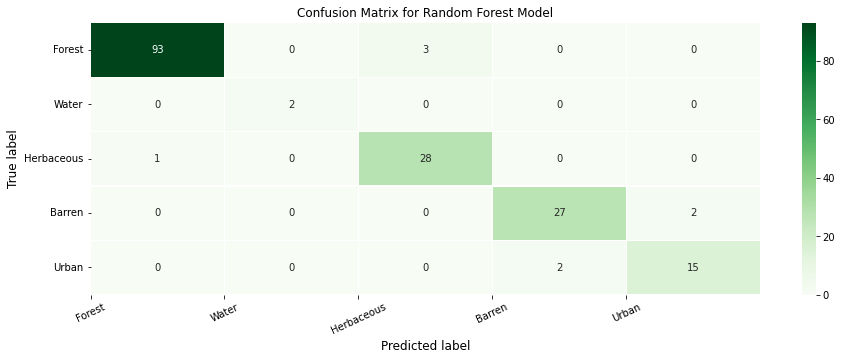

In [ ]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(Matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Forest', 'Water', 'Herbaceous', 'Barren', 'Urban']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

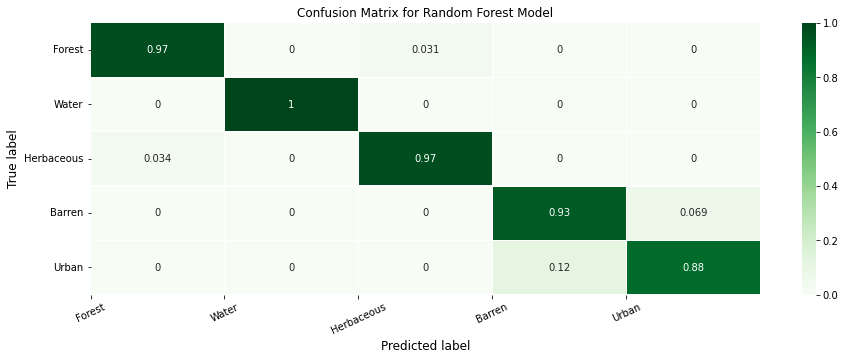

In [ ]:
# Build the plot
plt.figure(figsize=(15,5))
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['Forest', 'Water', 'Herbaceous', 'Barren', 'Urban']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25, fontsize=10)
plt.yticks(tick_marks2, class_names, rotation=0, fontsize=10)
plt.xlabel('Predicted label', fontsize=12)
plt.ylabel('True label', fontsize=12)
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

*Predicting the whole image*

In [ ]:
# Take our full image, ignore the Fmask band, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2] - 1)

img_as_array = img[:, :, :7].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
class_prediction = rfc_model.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img[:, :, 0].shape)

Reshaped from (250, 250, 8) to (62500, 7)


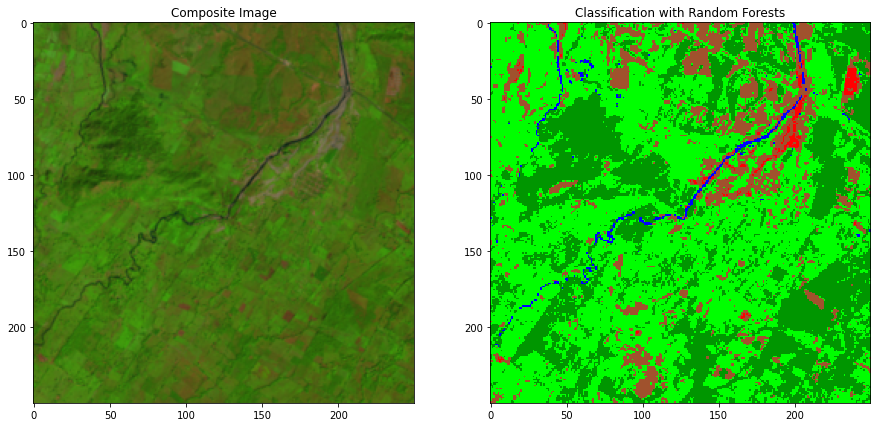

In [ ]:
# Visualize

# First setup a 5-4-3 composite
def color_stretch(image, index, minmax=(0, 10000)):
    colors = image[:, :, index].astype(np.float64)

    max_val = minmax[1]
    min_val = minmax[0]

    # Enforce maximum and minimum values
    colors[colors[:, :, :] > max_val] = max_val
    colors[colors[:, :, :] < min_val] = min_val

    for b in range(colors.shape[2]):
        colors[:, :, b] = colors[:, :, b] * 1 / (max_val - min_val)
        
    return colors
    
img543 = color_stretch(img, [4, 3, 2], (0, 8000))

# See https://github.com/matplotlib/matplotlib/issues/844/
n = class_prediction.max()
# Next setup a colormap for our map
colors = dict((
    (0, (0, 0, 0, 255)),  # Nodata
    (1, (0, 150, 0, 255)),  # Forest
    (2, (0, 0, 255, 255)),  # Water
    (3, (0, 255, 0, 255)),  # Herbaceous
    (4, (160, 82, 45, 255)),  # Barren
    (5, (255, 0, 0, 255))  # Urban
))
# Put 0 - 255 as float 0 - 1
for k in colors:
    v = colors[k]
    _v = [_v / 255.0 for _v in v]
    colors[k] = _v
    
index_colors = [colors[key] if key in colors else 
                (255, 255, 255, 0) for key in range(1, n + 1)]
cmap = plt.matplotlib.colors.ListedColormap(index_colors, 'Classification', n)

# Now show the classmap next to the image
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(img543)
plt.title('Composite Image')


plt.subplot(122)
plt.imshow(class_prediction, cmap=cmap, interpolation='none')
plt.title('Classification with Random Forests')

plt.show()